In [139]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,KBinsDiscretizer,LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.kernel_approximation import Nystroem

from sklearn.model_selection import StratifiedKFold

from catboost import Pool, cv,CatBoostClassifier,CatBoostRegressor

from tqdm import tqdm

# Catboost predictions

In [140]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
submission_df = pd.read_csv('sample_submission.csv')

In [141]:
stacking_train_df = pd.read_csv('stacking_train_df.csv')
stacking_test_df = pd.read_csv('stacking_test_df.csv')

In [142]:
stacking_train_df.head()

,catboost_low_corr,catboost_autoencoder,nn_base,nn_linear_pred,nn_comb,catboost_anomaly,light_gbm_catboost_features,light_gbm_base,catboost_base
0,2.957802,3.0,1.799978,1.790162,1.965532,2.813200,2.925673,2.924333,2.967996
1,2.961396,3.0,1.866792,1.702062,2.006418,2.813200,2.966980,2.980262,2.971522
2,2.965646,3.0,1.837732,1.869186,1.965488,2.813200,2.967480,2.943718,2.971149
3,2.951560,3.0,2.026852,2.017801,1.512873,2.813200,2.999064,2.975820,2.964370
4,2.915263,3.0,1.753367,1.595990,1.946649,2.426473,2.986798,3.049662,2.929122


In [143]:
train_anomaly = pd.read_csv('train_df_anomaly.csv')
test_anomaly = pd.read_csv('test_df_anomaly.csv')

In [144]:
stacking_train_df['label'] = train_df['label']

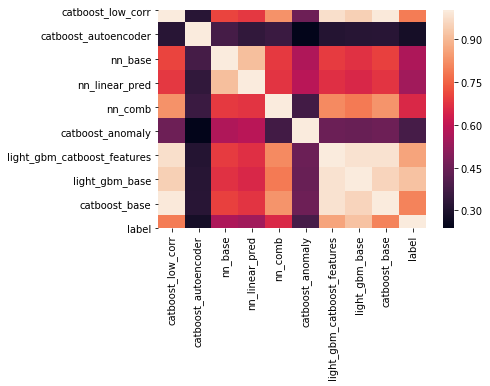

In [145]:
sns.heatmap(stacking_train_df.corr())

In [146]:
stacking_train_df.corr()['label']

catboost_low_corr              0.790748
catboost_autoencoder           0.281339
nn_base                        0.565504
nn_linear_pred                 0.544315
nn_comb                        0.653023
catboost_anomaly               0.380716
light_gbm_catboost_features    0.862837
light_gbm_base                 0.919675
catboost_base                  0.803230
label                          1.000000
Name: label, dtype: float64

In [147]:
stacking_train_df.columns

Index(['catboost_low_corr', 'catboost_autoencoder', 'nn_base',
       'nn_linear_pred', 'nn_comb', 'catboost_anomaly',
       'light_gbm_catboost_features', 'light_gbm_base', 'catboost_base',
       'label'],
      dtype='object')

In [148]:
features = [
    'catboost_low_corr', 
    'catboost_autoencoder', 
    'nn_base',
    'nn_linear_pred', 
    'nn_comb', 
    'catboost_anomaly',
    'light_gbm_catboost_features', 
    'light_gbm_base', 
    'catboost_base'
]

cat_features = []

# Catboost stacking

In [149]:
y = stacking_train_df['label'].values
X_train_df = stacking_train_df[features]
X_test_df = stacking_test_df[features]

In [150]:
params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
}

In [151]:
submission_pool = Pool(data=X_test_df, cat_features=cat_features)

In [152]:
skf = StratifiedKFold(n_splits=3)
validation_scores = []
submission_preds = np.zeros(submission_df.shape[0])
train_pools = []
models = []
for train_index, test_index in skf.split(X_train_df, y):
    X_train, X_test = X_train_df.iloc[train_index,:], X_train_df.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    pred = model.predict(test_pool)
    validation_score = model.best_score_['validation']['F1']
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    models.append(model)
    train_pools.append(train_pool)
    submission_preds += model.predict(submission_pool)

Learning rate set to 0.057693
0:	learn: 0.9886844	test: 0.9962125	best: 0.9962125 (0)	total: 21.4ms	remaining: 21.4s
10:	learn: 0.9956815	test: 0.9994175	best: 0.9996115 (5)	total: 72.7ms	remaining: 6.54s
20:	learn: 0.9981060	test: 1.0000000	best: 1.0000000 (13)	total: 120ms	remaining: 5.58s
30:	learn: 0.9988342	test: 1.0000000	best: 1.0000000 (13)	total: 166ms	remaining: 5.19s
40:	learn: 0.9991743	test: 1.0000000	best: 1.0000000 (13)	total: 220ms	remaining: 5.16s
50:	learn: 0.9992714	test: 1.0000000	best: 1.0000000 (13)	total: 270ms	remaining: 5.02s
60:	learn: 0.9993199	test: 1.0000000	best: 1.0000000 (13)	total: 315ms	remaining: 4.85s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1
bestIteration = 13

Shrink model to first 14 iterations.
Validation f1 1.0
Learning rate set to 0.057693
0:	learn: 0.9915983	test: 0.9900875	best: 0.9900875 (0)	total: 4.75ms	remaining: 4.75s
10:	learn: 0.9964544	test: 0.9961135	best: 0.9961135 (9)	total: 57.3ms	remaining: 5.15s
20:	lea

In [153]:
np.mean(validation_scores), np.std(validation_scores)

(0.99886789464213, 0.0013356782524140568)

In [154]:
submission_df['prediction'] = np.where(submission_preds > 2, 1, 0)
submission_df.to_csv('submission_stack.csv',index=False)

In [155]:
best_model = models[np.argmax(validation_scores)]

In [156]:
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,light_gbm_base,63.170295
1,light_gbm_catboost_features,15.040171
2,catboost_low_corr,6.734498
3,catboost_base,4.101505
4,nn_base,3.450353
5,catboost_anomaly,3.040545
6,nn_linear_pred,2.265245
7,nn_comb,2.122499
8,catboost_autoencoder,0.074889
